In [1]:
import os
import cv2
import pandas as pd
import xml.etree.ElementTree as et
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import shutil

np.random.seed(123)

%matplotlib inline

In [2]:
data_path = "../testDataset//"
output_path = "../testDataset/RESULT/"
train_path = "../testDataset/train/"
validation_path = "../testDataset/validation/"
test_path = "../testDataset/test/"
for path in [output_path,train_path,validation_path]:
    if not os.path.isdir(path):
        os.mkdir(path)

In [3]:
backgrounds = [[data_path+"background0{}".format(el),"bg0{}".format(el)] for el in range(1,6)]
# background = backgrounds[0][0]
# bg = backgrounds[0][1]
# videos = [el for el in os.listdir(background) if ".avi" in el]
# video = videos[0]

# xmls = [el for el in os.listdir(background) if ".xml" in el]
# xml = xmls[0]

# im_path = os.path.join(background,video)

In [4]:
# show results
def show_landmarks(image, landmarks):
    """Show image with landmarks"""
    plt.imshow(image)
    plt.scatter(landmarks[:, 0], landmarks[:, 1], s=50, marker='.', c='r')
    plt.pause(0.001)  # pause a bit so that plots are updated

In [20]:
clean_df = pd.read_csv("DeePaperScan/clean_df.csv",sep=";")
clean_list = clean_df['filenames'].tolist()
to_remove = set(clean_list) - set(os.listdir("DeePaperScan/train/"))
clean_df= clean_df[~clean_df.filenames.isin(to_remove)]

In [21]:
# Split files to train / validation
from sklearn.model_selection import train_test_split

train, val = train_test_split(clean_df, test_size=0.01)

for sample in [[train,train_path],[val,validation_path]]:
    filenames = sample[0]["filenames"].values.tolist()
    for filename in filenames:
        shutil.copyfile(os.path.join(output_path,filename),os.path.join(sample[1],filename))

In [23]:
train.shape, clean_df.shape
# set(os.listdir(train_path)) - set(clean_df.filenames.tolist())

((6890, 9), (6960, 9))

## RESIZE IMAGES & ANNOTATIONS

In [24]:
# https://github.com/fizyr/keras-retinanet/blob/8f7e7414db193832572773ea503c26edab405b96/keras_retinanet/utils/image.py
def resize_image(img, min_side=800, max_side=1333):
    """ Resize an image such that the size is constrained to min_side and max_side.
    Args
        min_side: The image's min side will be equal to min_side after resizing.
        max_side: If after resizing the image's max side is above max_side, resize until the max side is equal to max_side.
    Returns
        A resized image.
    """
    (rows, cols, _) = img.shape

    smallest_side = min(rows, cols)

    # rescale the image so the smallest side is min_side
    scale = min_side / smallest_side

    # check if the largest side is now greater than max_side, which can happen
    # when images have a large aspect ratio
    largest_side = max(rows, cols)
    if largest_side * scale > max_side:
        scale = max_side / largest_side

    # resize the image with the computed scale
    img = cv2.resize(img, None, fx=scale, fy=scale)
    return img, scale

In [25]:
%%time

X_val = []
y_val = []
X_train = []
y_train = []

for IDX,DF_path in enumerate([[train,train_path],[val,validation_path]]):
    for img_name in DF_path[0].filenames.values.tolist():
        img = Image.open(os.path.join(DF_path[1], img_name))
        annotation = np.array(DF_path[0][DF_path[0].filenames==img_name].drop("filenames",axis=1),dtype = 'float')
        
        # convert the image to grayscale
        gs_image = np.array(img.convert(mode='L')).reshape(1080,1920,1)
        # resize image
        image_sc, scale = resize_image(gs_image,300,350)
        image_sc = image_sc.reshape(image_sc.shape[0],image_sc.shape[1],1)
        # apply resizing to annotations too
        annotation_sc = annotation * scale

        if IDX==0:
            X_train.append(image_sc)
            y_train.append(annotation_sc)
        else:
            X_val.append(image_sc)
            y_val.append(annotation_sc)

X_train_ = np.array(X_train, dtype='float')
y_train_ = np.array(y_train,dtype='float')
y_train_ = y_train_.reshape(y_train_.shape[0],y_train_.shape[2])

X_val_ = np.array(X_val, dtype='float')
y_val_ = np.array(y_val,dtype='float')
y_val_ = y_val_.reshape(y_val_.shape[0],y_val_.shape[2])

CPU times: user 2min 24s, sys: 806 ms, total: 2min 24s
Wall time: 2min 24s


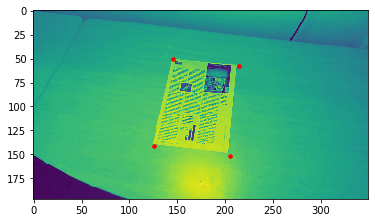

In [26]:
#check if landmarks well positioned after image scaling
IDX = np.random.randint(0,4000)
landmarks = y_train_[IDX].astype('float').reshape(-1, 2)

show_landmarks(Image.fromarray(X_train[IDX].reshape(X_train_.shape[1],X_train_.shape[2])),landmarks)
# show_landmarks(Image.fromarray(X_train[IDX]),landmarks)
plt.show()

## KERAS MODEL TRAINING

In [22]:
from tensorflow.keras.layers import Conv2D,Dropout,Dense,Flatten,Dense,GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications.vgg16 import preprocess_input, VGG16, preprocess_input

from tensorflow.keras.applications import MobileNet
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.mobilenet import preprocess_input

# from tensorflow.keras.layers.advanced_activations import LeakyReLU
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LeakyReLU, Activation, Convolution2D, MaxPooling2D, BatchNormalization, Flatten, Dense, Dropout, Conv2D,MaxPool2D, ZeroPadding2D

H = X_train_.shape[1]
W = X_train_.shape[2]
OUT = 8

In [75]:
model = Sequential()
model.add(Dense(100,input_dim=(W)))
model.add(Activation('relu'))
model.add(Dense(OUT))


sgd = SGD(lr=0.01, momentum=0.9, nesterov=True)
model.compile(loss='mean_squared_error', optimizer=sgd)

In [80]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D,Flatten, Dropout
from tensorflow.keras.optimizers import SGD, RMSprop, Adam

def SimpleCNN(withDropout=True):
    '''
    WithDropout: If True, then dropout regularlization is added.
    This feature is experimented later.
    '''
    model = Sequential()
    model.add(Conv2D(32,(3, 3), input_shape = (H, W, 1)))
    model.add(Activation('relu')) ## 96 - 3 + 2
    model.add(MaxPooling2D(pool_size = (2,2))) ## 96 - (3-1)*2
    if withDropout:
        model.add(Dropout(0.1))
        
    model.add(Conv2D(64,(2,2)))
    model.add(Activation('relu')) ## 
    model.add(MaxPooling2D(pool_size = (2,2)))
    if withDropout:
        model.add(Dropout(0.1))
    
    model.add(Conv2D(128,(2,2)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    if withDropout:
        model.add(Dropout(0.1))
        
    model.add(Flatten())
    
    model.add(Dense(500))
    model.add(Activation('relu'))
    if withDropout:
        model.add(Dropout(0.1))
        
    model.add(Dense(500))
    model.add(Activation('relu'))
    if withDropout:
        model.add(Dropout(0.1))
        
    model.add(Dense(OUT))
    sgd = SGD(lr=0.01,momentum = 0.9,nesterov=True)
#     model.compile(loss="mean_squared_error",optimizer=sgd)
    model.compile(optimizer=RMSprop(), 
              loss='mean_squared_logarithmic_error',#'mean_squared_error',
              metrics=['mae'])
    return(model)
simplecnn = SimpleCNN()

In [81]:
#check if gpu is activated

from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
tf.test.is_built_with_cuda()
tf.test.is_gpu_available(
    cuda_only=False,
    min_cuda_compute_capability=None
)

Num GPUs Available:  1


True

In [82]:
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
path_weights = "./simplecnn.h5"

es   = EarlyStopping(monitor='val_loss', patience = 100, mode='min')
mc = ModelCheckpoint(filepath = path_weights, monitor='val_loss', mode='min',save_best_only = True, verbose=2)
h1 = simplecnn.fit(X_train_,y_train_,epochs = 1000,batch_size = 64,validation_split = 0.1,
                   callbacks=[mc], verbose=2) #edit

Train on 6209 samples, validate on 690 samples
Epoch 1/1000

Epoch 00001: val_loss improved from inf to 12.98917, saving model to ./simplecnn.h5
6209/6209 - 12s - loss: 16.6858 - mae: 675.5933 - val_loss: 12.9892 - val_mae: 137.6661
Epoch 2/1000

Epoch 00002: val_loss improved from 12.98917 to 8.10923, saving model to ./simplecnn.h5
6209/6209 - 11s - loss: 9.0493 - mae: 119.8679 - val_loss: 8.1092 - val_mae: 94.9841
Epoch 3/1000

Epoch 00003: val_loss improved from 8.10923 to 2.45703, saving model to ./simplecnn.h5
6209/6209 - 11s - loss: 4.8850 - mae: 68.3791 - val_loss: 2.4570 - val_mae: 83.8184
Epoch 4/1000

Epoch 00004: val_loss improved from 2.45703 to 2.07443, saving model to ./simplecnn.h5
6209/6209 - 11s - loss: 2.0073 - mae: 42.9442 - val_loss: 2.0744 - val_mae: 45.2366
Epoch 5/1000

Epoch 00005: val_loss improved from 2.07443 to 0.25280, saving model to ./simplecnn.h5
6209/6209 - 11s - loss: 1.5167 - mae: 38.7230 - val_loss: 0.2528 - val_mae: 54.0642
Epoch 6/1000

Epoch 00006

Epoch 53/1000

Epoch 00053: val_loss did not improve from 0.01797
6209/6209 - 10s - loss: 0.0135 - mae: 11.3653 - val_loss: 0.2008 - val_mae: 49.9841
Epoch 54/1000

Epoch 00054: val_loss did not improve from 0.01797
6209/6209 - 10s - loss: 0.0139 - mae: 11.7138 - val_loss: 0.1341 - val_mae: 42.0419
Epoch 55/1000

Epoch 00055: val_loss did not improve from 0.01797
6209/6209 - 10s - loss: 0.0148 - mae: 11.6604 - val_loss: 0.1402 - val_mae: 42.5981
Epoch 56/1000

Epoch 00056: val_loss did not improve from 0.01797
6209/6209 - 10s - loss: 0.0144 - mae: 11.6838 - val_loss: 0.0488 - val_mae: 26.7129
Epoch 57/1000

Epoch 00057: val_loss did not improve from 0.01797
6209/6209 - 10s - loss: 0.0130 - mae: 11.5955 - val_loss: 0.0386 - val_mae: 23.6646
Epoch 58/1000

Epoch 00058: val_loss did not improve from 0.01797
6209/6209 - 10s - loss: 0.0149 - mae: 12.0704 - val_loss: 0.0936 - val_mae: 36.4672
Epoch 59/1000

Epoch 00059: val_loss did not improve from 0.01797
6209/6209 - 10s - loss: 0.0136 - m

Epoch 108/1000

Epoch 00108: val_loss did not improve from 0.01797
6209/6209 - 10s - loss: 0.0148 - mae: 11.4273 - val_loss: 0.0644 - val_mae: 24.7352
Epoch 109/1000

Epoch 00109: val_loss did not improve from 0.01797
6209/6209 - 10s - loss: 0.0124 - mae: 11.1073 - val_loss: 0.2934 - val_mae: 57.2157
Epoch 110/1000

Epoch 00110: val_loss did not improve from 0.01797
6209/6209 - 10s - loss: 0.0117 - mae: 10.9876 - val_loss: 0.0378 - val_mae: 24.1624
Epoch 111/1000

Epoch 00111: val_loss did not improve from 0.01797
6209/6209 - 10s - loss: 0.0140 - mae: 11.9072 - val_loss: 0.1902 - val_mae: 47.2333
Epoch 112/1000

Epoch 00112: val_loss did not improve from 0.01797
6209/6209 - 10s - loss: 0.0124 - mae: 10.8803 - val_loss: 0.1453 - val_mae: 42.9345
Epoch 113/1000

Epoch 00113: val_loss did not improve from 0.01797
6209/6209 - 10s - loss: 0.0118 - mae: 11.0077 - val_loss: 0.1410 - val_mae: 42.7814
Epoch 114/1000

Epoch 00114: val_loss did not improve from 0.01797
6209/6209 - 10s - loss: 0.0

Epoch 162/1000

Epoch 00162: val_loss did not improve from 0.01351
6209/6209 - 10s - loss: 0.0189 - mae: 12.0252 - val_loss: 0.1945 - val_mae: 48.5426
Epoch 163/1000

Epoch 00163: val_loss did not improve from 0.01351
6209/6209 - 10s - loss: 0.0260 - mae: 13.4409 - val_loss: 0.0862 - val_mae: 33.9520
Epoch 164/1000

Epoch 00164: val_loss did not improve from 0.01351
6209/6209 - 10s - loss: 0.0250 - mae: 11.0239 - val_loss: 0.2736 - val_mae: 55.2168
Epoch 165/1000

Epoch 00165: val_loss did not improve from 0.01351
6209/6209 - 10s - loss: 0.0251 - mae: 13.7452 - val_loss: 0.2693 - val_mae: 55.2508
Epoch 166/1000

Epoch 00166: val_loss did not improve from 0.01351
6209/6209 - 10s - loss: 0.0120 - mae: 10.9849 - val_loss: 0.0866 - val_mae: 35.1984
Epoch 167/1000

Epoch 00167: val_loss did not improve from 0.01351
6209/6209 - 10s - loss: 0.0111 - mae: 10.8035 - val_loss: 0.0334 - val_mae: 22.8977
Epoch 168/1000

Epoch 00168: val_loss did not improve from 0.01351
6209/6209 - 10s - loss: 0.0

Epoch 217/1000

Epoch 00217: val_loss did not improve from 0.01351
6209/6209 - 10s - loss: 0.0117 - mae: 10.8404 - val_loss: 0.0230 - val_mae: 18.4596
Epoch 218/1000

Epoch 00218: val_loss did not improve from 0.01351
6209/6209 - 10s - loss: 0.0121 - mae: 10.8813 - val_loss: 0.1202 - val_mae: 40.2961
Epoch 219/1000

Epoch 00219: val_loss did not improve from 0.01351
6209/6209 - 10s - loss: 0.0107 - mae: 10.4790 - val_loss: 0.0935 - val_mae: 36.6628
Epoch 220/1000

Epoch 00220: val_loss did not improve from 0.01351
6209/6209 - 10s - loss: 0.0114 - mae: 10.6157 - val_loss: 0.1491 - val_mae: 44.1757
Epoch 221/1000

Epoch 00221: val_loss did not improve from 0.01351
6209/6209 - 10s - loss: 0.0105 - mae: 10.3753 - val_loss: 0.0848 - val_mae: 34.7068
Epoch 222/1000

Epoch 00222: val_loss did not improve from 0.01351
6209/6209 - 10s - loss: 0.0102 - mae: 10.1680 - val_loss: 0.1804 - val_mae: 47.4824
Epoch 223/1000

Epoch 00223: val_loss did not improve from 0.01351
6209/6209 - 10s - loss: 0.0

Epoch 272/1000

Epoch 00272: val_loss did not improve from 0.01351
6209/6209 - 10s - loss: 0.0114 - mae: 11.1375 - val_loss: 0.1087 - val_mae: 38.7595
Epoch 273/1000

Epoch 00273: val_loss did not improve from 0.01351
6209/6209 - 10s - loss: 0.0120 - mae: 10.9445 - val_loss: 0.1075 - val_mae: 37.7025
Epoch 274/1000

Epoch 00274: val_loss did not improve from 0.01351
6209/6209 - 10s - loss: 0.0141 - mae: 11.5492 - val_loss: 0.0935 - val_mae: 36.1546
Epoch 275/1000

Epoch 00275: val_loss did not improve from 0.01351
6209/6209 - 10s - loss: 0.0124 - mae: 11.0174 - val_loss: 0.1250 - val_mae: 41.0471
Epoch 276/1000

Epoch 00276: val_loss did not improve from 0.01351
6209/6209 - 10s - loss: 0.0100 - mae: 10.0954 - val_loss: 0.2376 - val_mae: 52.8407
Epoch 277/1000

Epoch 00277: val_loss did not improve from 0.01351
6209/6209 - 10s - loss: 0.0099 - mae: 10.0003 - val_loss: 0.0410 - val_mae: 25.2301
Epoch 278/1000

Epoch 00278: val_loss did not improve from 0.01351
6209/6209 - 10s - loss: 0.0


Epoch 00324: val_loss did not improve from 0.00337
6209/6209 - 10s - loss: 0.0027 - mae: 4.8062 - val_loss: 0.0042 - val_mae: 4.3854
Epoch 325/1000

Epoch 00325: val_loss did not improve from 0.00337
6209/6209 - 10s - loss: 0.0023 - mae: 4.5626 - val_loss: 0.0049 - val_mae: 4.9496
Epoch 326/1000

Epoch 00326: val_loss did not improve from 0.00337
6209/6209 - 10s - loss: 0.0024 - mae: 4.6454 - val_loss: 0.0042 - val_mae: 4.6208
Epoch 327/1000

Epoch 00327: val_loss did not improve from 0.00337
6209/6209 - 10s - loss: 0.0024 - mae: 4.5648 - val_loss: 0.0044 - val_mae: 5.0267
Epoch 328/1000

Epoch 00328: val_loss did not improve from 0.00337
6209/6209 - 10s - loss: 0.0026 - mae: 4.6510 - val_loss: 0.0063 - val_mae: 5.6645
Epoch 329/1000

Epoch 00329: val_loss did not improve from 0.00337
6209/6209 - 10s - loss: 0.0021 - mae: 4.4472 - val_loss: 0.0093 - val_mae: 6.3927
Epoch 330/1000

Epoch 00330: val_loss did not improve from 0.00337
6209/6209 - 10s - loss: 0.0041 - mae: 5.1004 - val_los

Epoch 379/1000

Epoch 00379: val_loss did not improve from 0.00278
6209/6209 - 10s - loss: 0.0025 - mae: 4.1084 - val_loss: 0.0036 - val_mae: 4.1298
Epoch 380/1000

Epoch 00380: val_loss did not improve from 0.00278
6209/6209 - 10s - loss: 0.0015 - mae: 3.8252 - val_loss: 0.0041 - val_mae: 4.3359
Epoch 381/1000

Epoch 00381: val_loss did not improve from 0.00278
6209/6209 - 10s - loss: 0.0021 - mae: 4.0392 - val_loss: 0.0038 - val_mae: 3.8941
Epoch 382/1000

Epoch 00382: val_loss improved from 0.00278 to 0.00276, saving model to ./simplecnn.h5
6209/6209 - 11s - loss: 0.0016 - mae: 3.9430 - val_loss: 0.0028 - val_mae: 3.5249
Epoch 383/1000

Epoch 00383: val_loss did not improve from 0.00276
6209/6209 - 10s - loss: 0.0018 - mae: 3.9556 - val_loss: 0.0032 - val_mae: 3.9862
Epoch 384/1000

Epoch 00384: val_loss did not improve from 0.00276
6209/6209 - 10s - loss: 0.0017 - mae: 3.9498 - val_loss: 0.0033 - val_mae: 4.0217
Epoch 385/1000

Epoch 00385: val_loss did not improve from 0.00276
620

Epoch 434/1000

Epoch 00434: val_loss did not improve from 0.00276
6209/6209 - 10s - loss: 0.0016 - mae: 3.8295 - val_loss: 0.0042 - val_mae: 4.2001
Epoch 435/1000

Epoch 00435: val_loss did not improve from 0.00276
6209/6209 - 10s - loss: 0.0018 - mae: 3.9423 - val_loss: 0.0047 - val_mae: 4.1955
Epoch 436/1000

Epoch 00436: val_loss did not improve from 0.00276
6209/6209 - 10s - loss: 0.0019 - mae: 4.0165 - val_loss: 0.0052 - val_mae: 4.4169
Epoch 437/1000

Epoch 00437: val_loss did not improve from 0.00276
6209/6209 - 10s - loss: 0.0015 - mae: 3.7775 - val_loss: 0.0045 - val_mae: 4.0626
Epoch 438/1000

Epoch 00438: val_loss did not improve from 0.00276
6209/6209 - 10s - loss: 0.0019 - mae: 3.9662 - val_loss: 0.0041 - val_mae: 4.0358
Epoch 439/1000

Epoch 00439: val_loss did not improve from 0.00276
6209/6209 - 10s - loss: 0.0018 - mae: 3.9779 - val_loss: 0.0043 - val_mae: 4.2061
Epoch 440/1000

Epoch 00440: val_loss did not improve from 0.00276
6209/6209 - 10s - loss: 0.0016 - mae: 3

Epoch 489/1000

Epoch 00489: val_loss did not improve from 0.00276
6209/6209 - 10s - loss: 0.0016 - mae: 3.8169 - val_loss: 0.0050 - val_mae: 4.1824
Epoch 490/1000

Epoch 00490: val_loss did not improve from 0.00276
6209/6209 - 10s - loss: 0.0017 - mae: 3.8227 - val_loss: 0.0045 - val_mae: 4.0532
Epoch 491/1000

Epoch 00491: val_loss did not improve from 0.00276
6209/6209 - 10s - loss: 0.0018 - mae: 3.8747 - val_loss: 0.0045 - val_mae: 3.9867
Epoch 492/1000

Epoch 00492: val_loss did not improve from 0.00276
6209/6209 - 10s - loss: 0.0016 - mae: 3.7868 - val_loss: 0.0049 - val_mae: 4.4802
Epoch 493/1000

Epoch 00493: val_loss did not improve from 0.00276
6209/6209 - 10s - loss: 0.0017 - mae: 3.8286 - val_loss: 0.0042 - val_mae: 3.9414
Epoch 494/1000

Epoch 00494: val_loss did not improve from 0.00276
6209/6209 - 10s - loss: 0.0016 - mae: 3.8231 - val_loss: 0.0049 - val_mae: 4.4885
Epoch 495/1000

Epoch 00495: val_loss did not improve from 0.00276
6209/6209 - 10s - loss: 0.0016 - mae: 3

Epoch 544/1000

Epoch 00544: val_loss did not improve from 0.00276
6209/6209 - 10s - loss: 0.0016 - mae: 3.7715 - val_loss: 0.0056 - val_mae: 4.7191
Epoch 545/1000

Epoch 00545: val_loss did not improve from 0.00276
6209/6209 - 10s - loss: 0.0016 - mae: 3.8096 - val_loss: 0.0091 - val_mae: 6.3808
Epoch 546/1000

Epoch 00546: val_loss did not improve from 0.00276
6209/6209 - 10s - loss: 0.0017 - mae: 3.8017 - val_loss: 0.0046 - val_mae: 3.9764
Epoch 547/1000

Epoch 00547: val_loss did not improve from 0.00276
6209/6209 - 10s - loss: 0.0016 - mae: 3.7181 - val_loss: 0.0057 - val_mae: 4.5514
Epoch 548/1000

Epoch 00548: val_loss did not improve from 0.00276
6209/6209 - 10s - loss: 0.0017 - mae: 3.8002 - val_loss: 0.0047 - val_mae: 4.2320
Epoch 549/1000

Epoch 00549: val_loss did not improve from 0.00276
6209/6209 - 10s - loss: 0.0015 - mae: 3.7455 - val_loss: 0.0041 - val_mae: 4.0375
Epoch 550/1000

Epoch 00550: val_loss did not improve from 0.00276
6209/6209 - 10s - loss: 0.0016 - mae: 3

Epoch 599/1000

Epoch 00599: val_loss did not improve from 0.00276
6209/6209 - 10s - loss: 0.0015 - mae: 3.7174 - val_loss: 0.0044 - val_mae: 3.8713
Epoch 600/1000

Epoch 00600: val_loss did not improve from 0.00276
6209/6209 - 10s - loss: 0.0018 - mae: 3.8420 - val_loss: 0.0054 - val_mae: 5.0498
Epoch 601/1000

Epoch 00601: val_loss did not improve from 0.00276
6209/6209 - 10s - loss: 0.0015 - mae: 3.7173 - val_loss: 0.0040 - val_mae: 3.9958
Epoch 602/1000

Epoch 00602: val_loss did not improve from 0.00276
6209/6209 - 10s - loss: 0.0018 - mae: 3.7702 - val_loss: 0.0251 - val_mae: 9.0499
Epoch 603/1000

Epoch 00603: val_loss did not improve from 0.00276
6209/6209 - 10s - loss: 0.0018 - mae: 3.8026 - val_loss: 0.0041 - val_mae: 3.9638
Epoch 604/1000

Epoch 00604: val_loss did not improve from 0.00276
6209/6209 - 10s - loss: 0.0018 - mae: 3.8109 - val_loss: 0.0045 - val_mae: 4.2061
Epoch 605/1000

Epoch 00605: val_loss did not improve from 0.00276
6209/6209 - 10s - loss: 0.0016 - mae: 3

Epoch 654/1000

Epoch 00654: val_loss did not improve from 0.00276
6209/6209 - 10s - loss: 0.0016 - mae: 3.7407 - val_loss: 0.0035 - val_mae: 3.7660
Epoch 655/1000

Epoch 00655: val_loss did not improve from 0.00276
6209/6209 - 10s - loss: 0.0016 - mae: 3.7330 - val_loss: 0.0055 - val_mae: 4.7603
Epoch 656/1000

Epoch 00656: val_loss did not improve from 0.00276
6209/6209 - 10s - loss: 0.0016 - mae: 3.7538 - val_loss: 0.0063 - val_mae: 5.2976
Epoch 657/1000

Epoch 00657: val_loss did not improve from 0.00276
6209/6209 - 10s - loss: 0.0015 - mae: 3.7203 - val_loss: 0.0189 - val_mae: 8.1033
Epoch 658/1000

Epoch 00658: val_loss did not improve from 0.00276
6209/6209 - 10s - loss: 0.0015 - mae: 3.7297 - val_loss: 0.0042 - val_mae: 4.1923
Epoch 659/1000

Epoch 00659: val_loss did not improve from 0.00276
6209/6209 - 10s - loss: 0.0017 - mae: 3.8012 - val_loss: 0.0057 - val_mae: 4.5216
Epoch 660/1000

Epoch 00660: val_loss did not improve from 0.00276
6209/6209 - 10s - loss: 0.0017 - mae: 3

Epoch 709/1000

Epoch 00709: val_loss did not improve from 0.00276
6209/6209 - 10s - loss: 0.0016 - mae: 3.7194 - val_loss: 0.0045 - val_mae: 4.2332
Epoch 710/1000

Epoch 00710: val_loss did not improve from 0.00276
6209/6209 - 10s - loss: 0.0017 - mae: 3.8056 - val_loss: 0.0048 - val_mae: 4.1812
Epoch 711/1000

Epoch 00711: val_loss did not improve from 0.00276
6209/6209 - 10s - loss: 0.0015 - mae: 3.6812 - val_loss: 0.0044 - val_mae: 4.0270
Epoch 712/1000

Epoch 00712: val_loss did not improve from 0.00276
6209/6209 - 10s - loss: 0.0018 - mae: 3.7928 - val_loss: 0.0052 - val_mae: 4.7800
Epoch 713/1000

Epoch 00713: val_loss did not improve from 0.00276
6209/6209 - 10s - loss: 0.0015 - mae: 3.6442 - val_loss: 0.0048 - val_mae: 4.6549
Epoch 714/1000

Epoch 00714: val_loss did not improve from 0.00276
6209/6209 - 10s - loss: 0.0033 - mae: 4.1717 - val_loss: 0.0042 - val_mae: 4.0908
Epoch 715/1000

Epoch 00715: val_loss did not improve from 0.00276
6209/6209 - 10s - loss: 0.0017 - mae: 3

Epoch 764/1000

Epoch 00764: val_loss did not improve from 0.00276
6209/6209 - 10s - loss: 0.0016 - mae: 3.6713 - val_loss: 0.0047 - val_mae: 4.1316
Epoch 765/1000

Epoch 00765: val_loss did not improve from 0.00276
6209/6209 - 10s - loss: 0.0017 - mae: 3.7825 - val_loss: 0.0040 - val_mae: 4.2988
Epoch 766/1000

Epoch 00766: val_loss did not improve from 0.00276
6209/6209 - 10s - loss: 0.0015 - mae: 3.6505 - val_loss: 0.0041 - val_mae: 4.0004
Epoch 767/1000

Epoch 00767: val_loss did not improve from 0.00276
6209/6209 - 10s - loss: 0.0017 - mae: 3.7691 - val_loss: 0.0044 - val_mae: 4.0024
Epoch 768/1000

Epoch 00768: val_loss did not improve from 0.00276
6209/6209 - 10s - loss: 0.0016 - mae: 3.7260 - val_loss: 0.0043 - val_mae: 4.1305
Epoch 769/1000

Epoch 00769: val_loss did not improve from 0.00276
6209/6209 - 10s - loss: 0.0018 - mae: 3.7958 - val_loss: 0.0042 - val_mae: 3.9357
Epoch 770/1000

Epoch 00770: val_loss did not improve from 0.00276
6209/6209 - 10s - loss: 0.0015 - mae: 3

Epoch 819/1000

Epoch 00819: val_loss did not improve from 0.00276
6209/6209 - 10s - loss: 0.0018 - mae: 3.7866 - val_loss: 0.0040 - val_mae: 4.1164
Epoch 820/1000

Epoch 00820: val_loss did not improve from 0.00276
6209/6209 - 10s - loss: 0.0017 - mae: 3.8312 - val_loss: 0.0155 - val_mae: 8.4561
Epoch 821/1000

Epoch 00821: val_loss did not improve from 0.00276
6209/6209 - 10s - loss: 0.0383 - mae: 11.6232 - val_loss: 0.0045 - val_mae: 4.3272
Epoch 822/1000

Epoch 00822: val_loss did not improve from 0.00276
6209/6209 - 10s - loss: 0.0021 - mae: 3.9997 - val_loss: 0.0058 - val_mae: 4.6561
Epoch 823/1000

Epoch 00823: val_loss did not improve from 0.00276
6209/6209 - 10s - loss: 0.0017 - mae: 3.8372 - val_loss: 0.0051 - val_mae: 4.6042
Epoch 824/1000

Epoch 00824: val_loss did not improve from 0.00276
6209/6209 - 10s - loss: 0.0024 - mae: 4.0779 - val_loss: 0.0065 - val_mae: 4.6661
Epoch 825/1000

Epoch 00825: val_loss did not improve from 0.00276
6209/6209 - 10s - loss: 0.0018 - mae: 

Epoch 874/1000

Epoch 00874: val_loss did not improve from 0.00276
6209/6209 - 10s - loss: 0.0018 - mae: 3.8175 - val_loss: 0.0053 - val_mae: 4.4494
Epoch 875/1000

Epoch 00875: val_loss did not improve from 0.00276
6209/6209 - 10s - loss: 0.0020 - mae: 3.8961 - val_loss: 0.0065 - val_mae: 4.9938
Epoch 876/1000

Epoch 00876: val_loss did not improve from 0.00276
6209/6209 - 10s - loss: 0.0075 - mae: 4.8757 - val_loss: 0.0040 - val_mae: 4.0608
Epoch 877/1000

Epoch 00877: val_loss did not improve from 0.00276
6209/6209 - 10s - loss: 0.0018 - mae: 3.8492 - val_loss: 0.0724 - val_mae: 26.0316
Epoch 878/1000

Epoch 00878: val_loss did not improve from 0.00276
6209/6209 - 10s - loss: 0.0026 - mae: 4.1466 - val_loss: 0.0058 - val_mae: 4.7362
Epoch 879/1000

Epoch 00879: val_loss did not improve from 0.00276
6209/6209 - 11s - loss: 0.0066 - mae: 5.2456 - val_loss: 0.0059 - val_mae: 4.6014
Epoch 880/1000

Epoch 00880: val_loss did not improve from 0.00276
6209/6209 - 11s - loss: 0.0020 - mae: 

Epoch 929/1000

Epoch 00929: val_loss did not improve from 0.00276
6209/6209 - 10s - loss: 0.0056 - mae: 5.0010 - val_loss: 0.0054 - val_mae: 4.3929
Epoch 930/1000

Epoch 00930: val_loss did not improve from 0.00276
6209/6209 - 10s - loss: 0.0019 - mae: 3.8946 - val_loss: 0.0053 - val_mae: 4.4133
Epoch 931/1000

Epoch 00931: val_loss did not improve from 0.00276
6209/6209 - 10s - loss: 0.0019 - mae: 3.8919 - val_loss: 0.0109 - val_mae: 6.0792
Epoch 932/1000

Epoch 00932: val_loss did not improve from 0.00276
6209/6209 - 10s - loss: 0.0019 - mae: 3.8782 - val_loss: 0.0043 - val_mae: 4.2409
Epoch 933/1000

Epoch 00933: val_loss did not improve from 0.00276
6209/6209 - 10s - loss: 0.0017 - mae: 3.8014 - val_loss: 0.0051 - val_mae: 4.4554
Epoch 934/1000

Epoch 00934: val_loss did not improve from 0.00276
6209/6209 - 10s - loss: 0.0023 - mae: 4.0598 - val_loss: 0.0067 - val_mae: 5.0428
Epoch 935/1000

Epoch 00935: val_loss did not improve from 0.00276
6209/6209 - 10s - loss: 0.0020 - mae: 3

KeyboardInterrupt: 

#### TEST

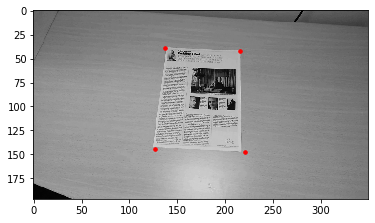

In [142]:
IDX = np.random.randint(2,70)
plt.imshow(X_val_[IDX].reshape(H,W),cmap = 'gray')
val_img = X_val_[IDX].reshape(1,X_val_[IDX].shape[0],X_val_[IDX].shape[1],X_val_[IDX].shape[2])
pred_landmarks = simplecnn.predict(val_img)

landmarks = pred_landmarks.reshape(-1, 2)

# show_landmarks(Image.open(os.path.join(validation_path, img_name)),landmarks)
show_landmarks(Image.fromarray(X_val_[IDX].reshape(H,W)),landmarks)
plt.show()

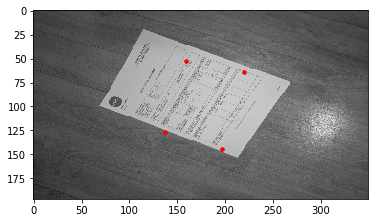

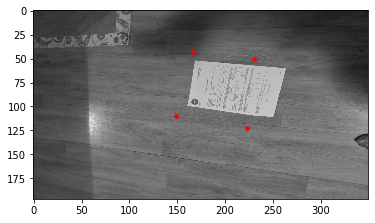

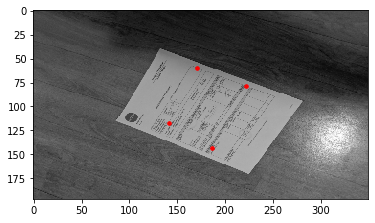

In [136]:
for idx in range(3):
    test_img = Image.open(os.path.join(test_path,os.listdir(test_path)[idx]))
    #resize
    resized_img = test_img.resize((1920, 1080), Image.BILINEAR)
    #grayscale
    gs_image =  np.array(resized_img.convert(mode='L'),dtype="float").reshape(1080,1920,1)
    # resize image
    image_sc, scale = resize_image(gs_image,300,350)
    #preditct
    pred_landmarks = simplecnn.predict(image_sc.reshape(1,H,W,1))
    landmarks = pred_landmarks.reshape(-1, 2)

    # show_landmarks(Image.open(os.path.join(validation_path, img_name)),landmarks)
    show_landmarks(Image.fromarray(image_sc),landmarks)
    plt.show()

### SAVE AND LOAD MODEL

In [ ]:
# serialize model to JSON
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model.h5")
print("Saved model to disk")

In [ ]:
from tensorflow.keras.models import model_from_json
# load json and create model
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
model = model_from_json(loaded_model_json)
# load weights into new model
model.load_weights("model.h5")
print("Loaded model from disk")

In [ ]:
H=197
W=350
for idx in range(3):
    test_img = Image.open(os.path.join(test_path,os.listdir(test_path)[idx]))
    #resize
    resized_img = test_img.resize((1920, 1080), Image.BILINEAR)
    #grayscale
    gs_image =  np.array(resized_img.convert(mode='L'),dtype="float").reshape(1080,1920,1)
    # resize image
    image_sc, scale = resize_image(gs_image,300,350)
    #preditct
    pred_landmarks = loaded_model.predict(image_sc.reshape(1,H,W,1))
    landmarks = pred_landmarks.reshape(-1, 2)

    # show_landmarks(Image.open(os.path.join(validation_path, img_name)),landmarks)
    show_landmarks(Image.fromarray(image_sc),landmarks)
    plt.show()

## NICETOHAVE COCO DATASET REMAKE

In [ ]:
# Create Coco Annotation files
AREA=BLX=BLY=BRX=BRY=TLX=TLY=TRX=TRY=ID=IMG_ID=xmin=xmax=ymin=ymax=filename=height=width=0

CAT_ANNOT  ={
            "supercategory": "document",
            "id": 1,
            "name": "document",
            "keypoints": [
                "bl","br","tl","tr"
            ],
            "skeleton": [
                [1,2],[1,3],[2,4],[3,4]
            ]
        }

ANNOT = {
            "segmentation": [[]],
            "num_keypoints": 4,
            "area": AREA,
            "iscrowd": 0,
            "keypoints": [BLX,BLY,2,BRX,BRY,2,TLX,TLY,2,TRX,TRY,2],
            "image_id": IMG_ID,
            "bbox": [xmin, ymin, xmax-xmin, ymax-ymin],
            "category_id": 1,
            "id": ID
        }
IMAGE = {
      "file_name": filename,
      "height": height,
      "width": width,
      "id": IMG_ID
    }


COCO_ANNOT  = {
  "images": [

  ],
    "categories": [

    ],
    "annotations": [

    ]
}
COCO_ANNOT["images"].append(IMAGE)
COCO_ANNOT["categories"].append(CAT_ANNOT)
COCO_ANNOT["annotations"].append(ANNOT)
COCO_ANNOT